# MLP (Multi-Layer Perceptron) - Análise de Consumo Doméstico de Energia

## Objetivo
Modelar e prever o consumo doméstico de energia usando redes neurais MLP (Multi-Layer Perceptron)

## Dataset
- **Arquivo**: household_consumption.xlsx
- **Variável Target**: Consumption (consumo de energia)
- **Frequência**: Dados por minuto
- **Abordagem**: Transformar série temporal em problema supervisionado

In [12]:
# Importações necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Deep Learning alternativo (se disponível)
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    KERAS_AVAILABLE = True
except ImportError:
    KERAS_AVAILABLE = False
    print("TensorFlow não disponível. Usando apenas scikit-learn.")

import joblib
import json
import os

# Configurações de visualização
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("husl")

# Diretório de saída (household_consumption)
output_dir = '../../out/household_consumption/MLP'
os.makedirs(output_dir, exist_ok=True)

# Seed para reprodutibilidade
np.random.seed(42)
if KERAS_AVAILABLE:
    tf.random.set_seed(42)

## 1. Carregamento e Preparação dos Dados

In [13]:
# Carregamento dos dados
data_path = '../../data/household_consumption.xlsx'
df = pd.read_excel(data_path, sheet_name='Sheet1')

# Preparação da série temporal
df['Date and Hour'] = pd.to_datetime(df['Date and Hour'])
df = df.set_index('Date and Hour')
df = df.sort_index()
df = df.dropna()

print("Informações básicas do dataset:")
print(f"Shape: {df.shape}")
print(f"Período: {df.index.min()} a {df.index.max()}")
print(f"Frequência: {pd.infer_freq(df.index)}")
print(f"\nEstatísticas descritivas:")
print(df['Consumption'].describe())

Informações básicas do dataset:
Shape: (5000, 1)
Período: 2006-12-16 16:24:00 a 2006-12-20 03:43:00
Frequência: min

Estatísticas descritivas:
count    5000.000000
mean        1.718148
std         1.301801
min         0.194000
25%         0.380000
50%         1.626000
75%         2.502000
max         7.840000
Name: Consumption, dtype: float64


## 2. Engenharia de Features para Séries Temporais

Criando features de lag e temporais...
Dataset com features: (4976, 46)

Features criadas:
['target', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'rolling_mean_3', 'rolling_std_3', 'rolling_min_3', 'rolling_max_3', 'rolling_mean_6', 'rolling_std_6', 'rolling_min_6', 'rolling_max_6', 'rolling_mean_12', 'rolling_std_12', 'rolling_min_12', 'rolling_max_12', 'rolling_mean_24', 'rolling_std_24', 'rolling_min_24', 'rolling_max_24', 'hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'diff_1', 'diff_24', 'trend_3', 'trend_6']
Dataset com features: (4976, 46)

Features criadas:
['target', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'rolling_mean_3', 'rolling_std_3', 'rolling_min_3', 'rolling_max_3', 'rolling_mean_6', 'rolling_std_6', 'ro

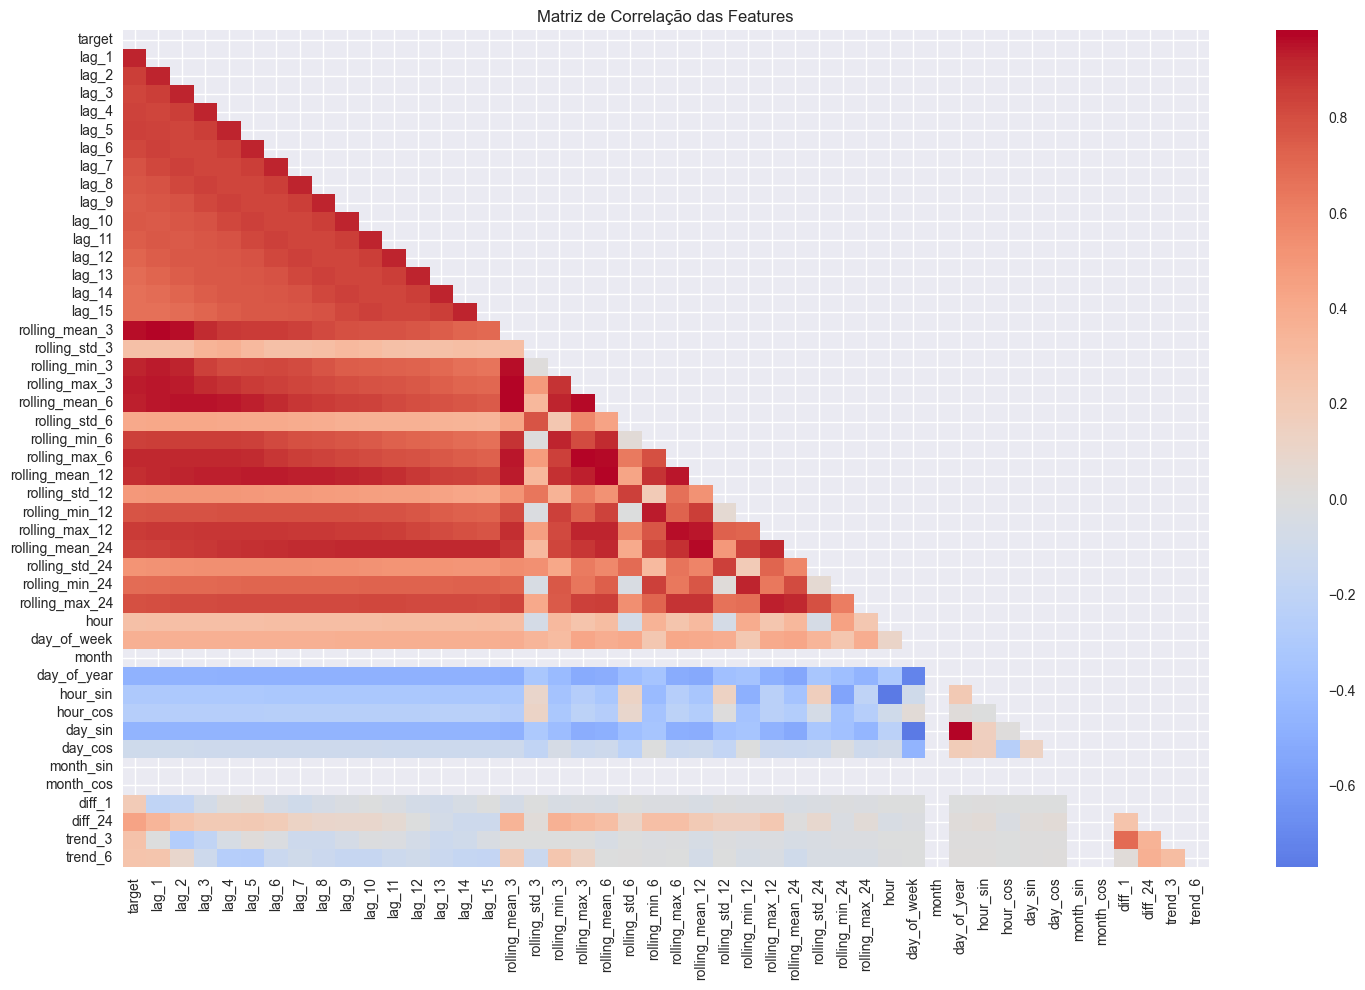


Top 10 features mais correlacionadas com o target:
target             1.000000
rolling_mean_3     0.959157
rolling_max_3      0.938250
rolling_mean_6     0.933194
lag_1              0.925485
rolling_min_3      0.923701
rolling_max_6      0.907376
rolling_mean_12    0.896569
rolling_max_12     0.863486
lag_2              0.857281
rolling_min_6      0.846958
Name: target, dtype: float64


In [14]:
def create_lag_features(data, n_lags=10):
    """
    Criar features de lag (valores passados) para MLP
    """
    df_features = pd.DataFrame(index=data.index)
    
    # Target original
    df_features['target'] = data['Consumption']
    
    # Features de lag
    for i in range(1, n_lags + 1):
        df_features[f'lag_{i}'] = data['Consumption'].shift(i)
    
    # Rolling statistics
    for window in [3, 6, 12, 24]:
        df_features[f'rolling_mean_{window}'] = data['Consumption'].rolling(window=window).mean()
        df_features[f'rolling_std_{window}'] = data['Consumption'].rolling(window=window).std()
        df_features[f'rolling_min_{window}'] = data['Consumption'].rolling(window=window).min()
        df_features[f'rolling_max_{window}'] = data['Consumption'].rolling(window=window).max()
    
    # Features temporais
    df_features['hour'] = data.index.hour
    df_features['day_of_week'] = data.index.dayofweek
    df_features['month'] = data.index.month
    df_features['day_of_year'] = data.index.dayofyear
    
    # Features cíclicas (codificação sin/cos)
    df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
    df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day_of_week'] / 7)
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    
    # Features de diferença
    df_features['diff_1'] = data['Consumption'].diff(1)
    df_features['diff_24'] = data['Consumption'].diff(24)  # diferença de 24 períodos (se houver sazonalidade diária)
    
    # Features de tendência local
    df_features['trend_3'] = data['Consumption'].rolling(3).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 3 else np.nan, raw=False)
    df_features['trend_6'] = data['Consumption'].rolling(6).apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) == 6 else np.nan, raw=False)
    
    return df_features

# Criar features
print("Criando features de lag e temporais...")
features_df = create_lag_features(df, n_lags=15)

# Remover linhas com NaN
features_df = features_df.dropna()

print(f"Dataset com features: {features_df.shape}")
print(f"\nFeatures criadas:")
print(list(features_df.columns))

# Visualizar correlações
plt.figure(figsize=(15, 10))
correlation_matrix = features_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação das Features')
plt.tight_layout()
plt.savefig(f'{output_dir}/mlp_01_feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Features mais correlacionadas com o target
target_corr = features_df.corr()['target'].abs().sort_values(ascending=False)
print(f"\nTop 10 features mais correlacionadas com o target:")
print(target_corr.head(11))  # 11 porque o próprio target está incluído

## 3. Preparação dos Dados para ML

Tamanho do conjunto de treino: (3980, 45)
Tamanho do conjunto de teste: (996, 45)
Período de treino: 2006-12-16 16:48:00 a 2006-12-19 11:07:00
Período de teste: 2006-12-19 11:08:00 a 2006-12-20 03:43:00

Normalização concluída.
Features shape: (3980, 45)
Target shape: (3980,)


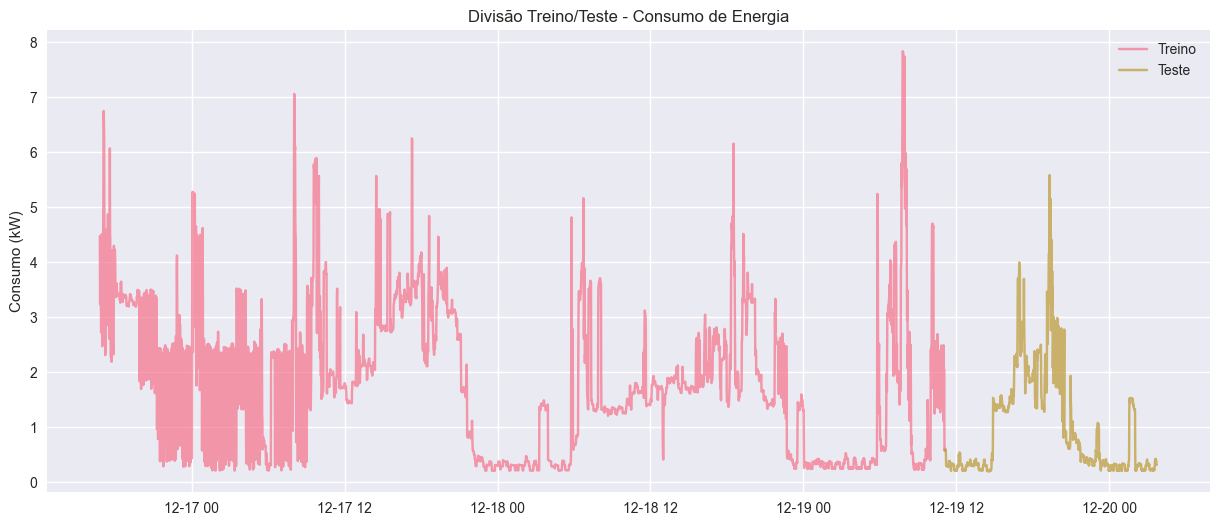

In [15]:
# Separar features e target
X = features_df.drop('target', axis=1)
y = features_df['target']

# Divisão temporal: 80% treino, 20% teste
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Período de treino: {X_train.index.min()} a {X_train.index.max()}")
print(f"Período de teste: {X_test.index.min()} a {X_test.index.max()}")

# Normalização das features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Também normalizar o target para algumas métricas
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

print(f"\nNormalização concluída.")
print(f"Features shape: {X_train_scaled.shape}")
print(f"Target shape: {y_train_scaled.shape}")

# Visualização da divisão
plt.figure(figsize=(15, 6))
plt.plot(y_train.index, y_train.values, label='Treino', alpha=0.7)
plt.plot(y_test.index, y_test.values, label='Teste', alpha=0.7)
plt.title('Divisão Treino/Teste - Consumo de Energia')
plt.ylabel('Consumo (kW)')
plt.legend()
plt.savefig(f'{output_dir}/mlp_02_train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Grid Search para Otimização de Hiperparâmetros - Scikit-learn MLP

In [16]:
# Grid search para MLPRegressor
print("Iniciando Grid Search para MLPRegressor...")

# Definir parâmetros para grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50), (100, 50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

# Time Series Cross Validation
tscv = TimeSeriesSplit(n_splits=5)

# MLPRegressor base
mlp_base = MLPRegressor(random_state=42, max_iter=500, early_stopping=True, validation_fraction=0.1)

# Grid Search
grid_search = GridSearchCV(
    mlp_base,
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Executar grid search (usar amostra menor se dataset for muito grande)
sample_size = min(10000, len(X_train_scaled))
grid_search.fit(X_train_scaled[:sample_size], y_train.iloc[:sample_size])

print(f"\nMelhores parâmetros: {grid_search.best_params_}")
print(f"Melhor score (CV): {-grid_search.best_score_:.6f}")

# Treinar modelo final com melhores parâmetros
best_mlp = grid_search.best_estimator_
best_mlp.fit(X_train_scaled, y_train)

# Previsões
y_pred_train = best_mlp.predict(X_train_scaled)
y_pred_test = best_mlp.predict(X_test_scaled)

# Métricas scikit-learn MLP
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print(f"\n=== Resultados Scikit-learn MLP ===")
print(f"Treino - RMSE: {train_rmse:.6f}, MAE: {train_mae:.6f}, R²: {train_r2:.6f}")
print(f"Teste - RMSE: {test_rmse:.6f}, MAE: {test_mae:.6f}, R²: {test_r2:.6f}, MAPE: {test_mape:.2f}%")

# Salvar modelo
joblib.dump(best_mlp, f'{output_dir}/mlp_sklearn_model.pkl')
joblib.dump(scaler, f'{output_dir}/mlp_scaler.pkl')

Iniciando Grid Search para MLPRegressor...
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Melhores parâmetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
Melhor score (CV): 0.061987

Melhores parâmetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50, 25), 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
Melhor score (CV): 0.061987

=== Resultados Scikit-learn MLP ===
Treino - RMSE: 0.009872, MAE: 0.007077, R²: 0.999942
Teste - RMSE: 0.050933, MAE: 0.043304, R²: 0.997072, MAPE: 9.62%

=== Resultados Scikit-learn MLP ===
Treino - RMSE: 0.009872, MAE: 0.007077, R²: 0.999942
Teste - RMSE: 0.050933, MAE: 0.043304, R²: 0.997072, MAPE: 9.62%


['../../out/household_consumption/MLP/mlp_scaler.pkl']

## 5. Modelo MLP com Keras/TensorFlow (se disponível)


=== Construindo MLP com Keras ===

Testando arquitetura 1: [64, 32]
RMSE: 0.069869, MAE: 0.056930, R²: 0.994490, MAPE: 12.16%

Testando arquitetura 2: [100, 50, 25]
RMSE: 0.069869, MAE: 0.056930, R²: 0.994490, MAPE: 12.16%

Testando arquitetura 2: [100, 50, 25]
RMSE: 0.226103, MAE: 0.192188, R²: 0.942301, MAPE: 55.42%

Testando arquitetura 3: [128, 64, 32]
RMSE: 0.226103, MAE: 0.192188, R²: 0.942301, MAPE: 55.42%

Testando arquitetura 3: [128, 64, 32]
RMSE: 0.120815, MAE: 0.093551, R²: 0.983526, MAPE: 21.09%

Testando arquitetura 4: [200, 100, 50, 25]
RMSE: 0.120815, MAE: 0.093551, R²: 0.983526, MAPE: 21.09%

Testando arquitetura 4: [200, 100, 50, 25]


RMSE: 0.093423, MAE: 0.070342, R²: 0.990149, MAPE: 12.96%

=== Melhor Modelo Keras ===
Arquitetura: [64, 32]
RMSE: 0.069869
Epoch 1/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3414 - mae: 0.3914 - val_loss: 0.0471 - val_mae: 0.1572 - learning_rate: 0.0010
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3414 - mae: 0.3914 - val_loss: 0.0471 - val_mae: 0.1572 - learning_rate: 0.0010
Epoch 2/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1107 - mae: 0.2464 - val_loss: 0.0319 - val_mae: 0.1301 - learning_rate: 0.0010
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1107 - mae: 0.2464 - val_loss: 0.0319 - val_mae: 0.1301 - learning_rate: 0.0010
Epoch 3/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0829 - mae: 0.2097 - val_loss: 0.0315 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 4/150
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0829 - mae: 0.2097 - val_loss: 0.0315 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 4/150
100/10

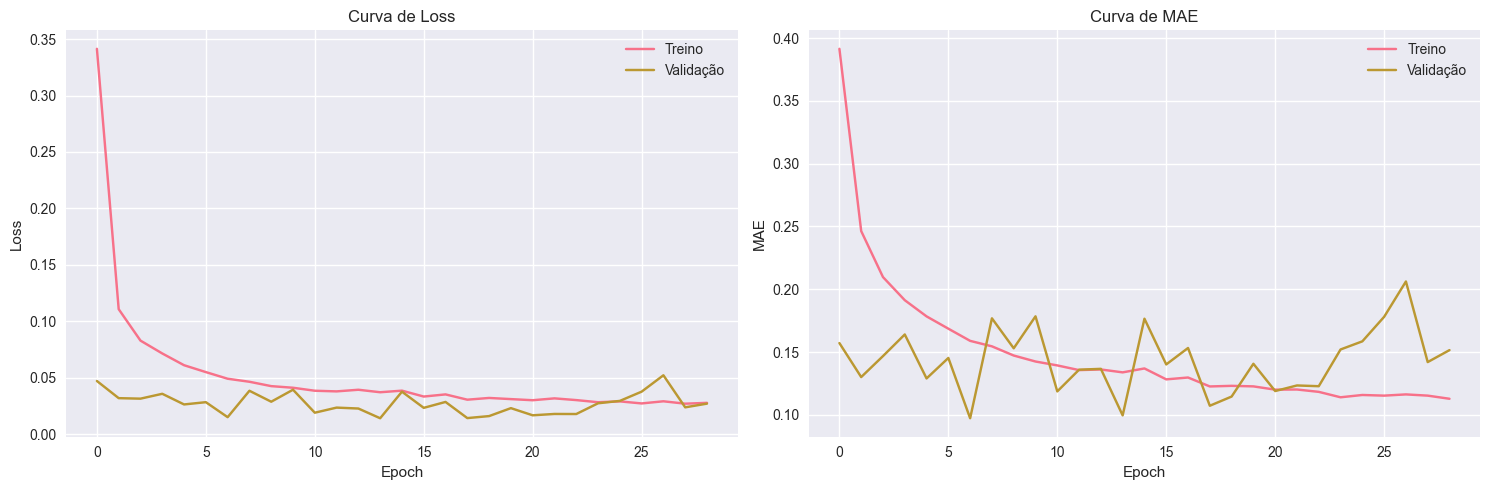

In [17]:
if KERAS_AVAILABLE:
    print("\n=== Construindo MLP com Keras ===")
    
    def create_mlp_model(input_dim, hidden_layers=[100, 50, 25], dropout_rate=0.2, learning_rate=0.001):
        """
        Criar modelo MLP com Keras
        """
        model = Sequential()
        
        # Primeira camada oculta
        model.add(Dense(hidden_layers[0], activation='relu', input_dim=input_dim))
        model.add(Dropout(dropout_rate))
        
        # Camadas ocultas adicionais
        for neurons in hidden_layers[1:]:
            model.add(Dense(neurons, activation='relu'))
            model.add(Dropout(dropout_rate))
        
        # Camada de saída
        model.add(Dense(1, activation='linear'))
        
        # Compilar modelo
        model.compile(optimizer=Adam(learning_rate=learning_rate),
                     loss='mse',
                     metrics=['mae'])
        
        return model
    
    # Configurações para teste
    architectures = [
        [64, 32],
        [100, 50, 25],
        [128, 64, 32],
        [200, 100, 50, 25]
    ]
    
    best_keras_model = None
    best_keras_score = float('inf')
    keras_results = []
    
    for i, architecture in enumerate(architectures):
        print(f"\nTestando arquitetura {i+1}: {architecture}")
        
        # Criar modelo
        model = create_mlp_model(X_train_scaled.shape[1], architecture)
        
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
        
        # Treinar modelo
        history = model.fit(
            X_train_scaled, y_train_scaled,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Previsões (desnormalizar)
        y_pred_keras = model.predict(X_test_scaled, verbose=0)
        y_pred_keras = target_scaler.inverse_transform(y_pred_keras).ravel()
        
        # Métricas
        keras_rmse = np.sqrt(mean_squared_error(y_test, y_pred_keras))
        keras_mae = mean_absolute_error(y_test, y_pred_keras)
        keras_r2 = r2_score(y_test, y_pred_keras)
        keras_mape = np.mean(np.abs((y_test - y_pred_keras) / y_test)) * 100
        
        print(f"RMSE: {keras_rmse:.6f}, MAE: {keras_mae:.6f}, R²: {keras_r2:.6f}, MAPE: {keras_mape:.2f}%")
        
        keras_results.append({
            'architecture': architecture,
            'rmse': keras_rmse,
            'mae': keras_mae,
            'r2': keras_r2,
            'mape': keras_mape,
            'epochs': len(history.history['loss'])
        })
        
        if keras_rmse < best_keras_score:
            best_keras_score = keras_rmse
            best_keras_model = model
            best_keras_predictions = y_pred_keras
            best_architecture = architecture
    
    print(f"\n=== Melhor Modelo Keras ===")
    print(f"Arquitetura: {best_architecture}")
    print(f"RMSE: {best_keras_score:.6f}")
    
    # Salvar melhor modelo Keras
    if best_keras_model:
        best_keras_model.save(f'{output_dir}/mlp_keras_model.h5')
        
        # Curvas de aprendizado do melhor modelo
        final_model = create_mlp_model(X_train_scaled.shape[1], best_architecture)
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-7)
        
        history = final_model.fit(
            X_train_scaled, y_train_scaled,
            epochs=150,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        
        # Plotar curvas de aprendizado
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Treino')
        plt.plot(history.history['val_loss'], label='Validação')
        plt.title('Curva de Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Treino')
        plt.plot(history.history['val_mae'], label='Validação')
        plt.title('Curva de MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/mlp_03_keras_learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Previsões finais
        final_predictions = final_model.predict(X_test_scaled, verbose=0)
        final_predictions = target_scaler.inverse_transform(final_predictions).ravel()
        
        # Usar as melhores previsões
        y_pred_keras_final = final_predictions
    
else:
    print("\nKeras não disponível. Continuando apenas com scikit-learn.")
    keras_results = []
    y_pred_keras_final = None

## 6. Análise de Overfitting e Validação


=== Análise de Overfitting ===
Scikit-learn MLP:
  RMSE Treino: 0.009872
  RMSE Teste: 0.050933
  Diferença: 0.041061
  % Diferença: 415.93%
  Status: Overfitting significativo ❌

=== Validação Cruzada Temporal ===
RMSE CV: 0.203717 ± 0.137708
Scores individuais: [0.23381322 0.11256229 0.46084438 0.11720799 0.0941548 ]
RMSE CV: 0.203717 ± 0.137708
Scores individuais: [0.23381322 0.11256229 0.46084438 0.11720799 0.0941548 ]


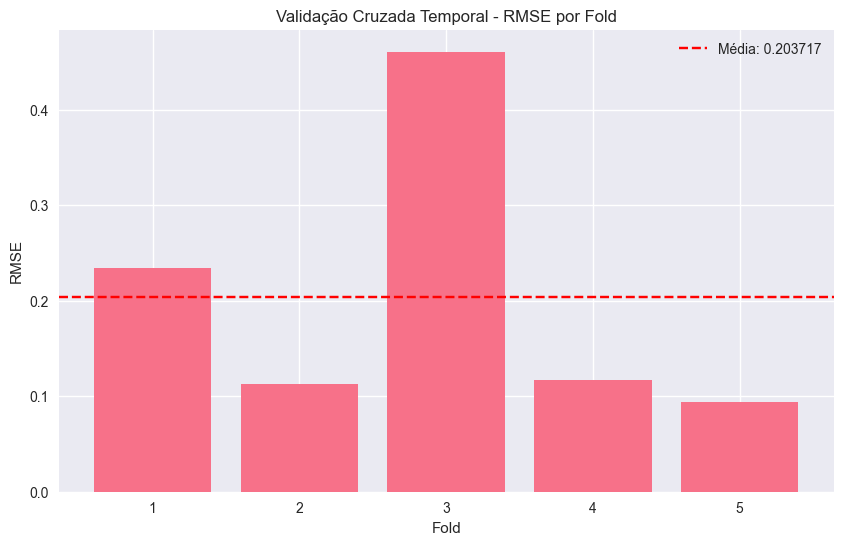

In [18]:
# Análise de overfitting para scikit-learn MLP
print("\n=== Análise de Overfitting ===")
print(f"Scikit-learn MLP:")
print(f"  RMSE Treino: {train_rmse:.6f}")
print(f"  RMSE Teste: {test_rmse:.6f}")
print(f"  Diferença: {abs(test_rmse - train_rmse):.6f}")
print(f"  % Diferença: {abs(test_rmse - train_rmse) / train_rmse * 100:.2f}%")

overfitting_sklearn = abs(test_rmse - train_rmse) / train_rmse * 100

if overfitting_sklearn < 10:
    print("  Status: Pouco overfitting ✓")
elif overfitting_sklearn < 25:
    print("  Status: Overfitting moderado ⚠️")
else:
    print("  Status: Overfitting significativo ❌")

# Cross-validation temporal para validação robusta
from sklearn.model_selection import cross_val_score

print("\n=== Validação Cruzada Temporal ===")
cv_scores = cross_val_score(best_mlp, X_train_scaled, y_train, 
                          cv=TimeSeriesSplit(n_splits=5), 
                          scoring='neg_mean_squared_error')

cv_rmse_scores = np.sqrt(-cv_scores)
print(f"RMSE CV: {cv_rmse_scores.mean():.6f} ± {cv_rmse_scores.std():.6f}")
print(f"Scores individuais: {cv_rmse_scores}")

# Visualizar scores de CV
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_rmse_scores)
plt.axhline(y=cv_rmse_scores.mean(), color='r', linestyle='--', label=f'Média: {cv_rmse_scores.mean():.6f}')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Validação Cruzada Temporal - RMSE por Fold')
plt.legend()
plt.savefig(f'{output_dir}/mlp_04_cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Análise de Features Importantes


=== Análise de Importância das Features ===
Calculando importância por permutação...

Top 15 features mais importantes:
            feature  importance       std
15   rolling_mean_3    0.070537  0.002225
19   rolling_mean_6    0.048876  0.001873
0             lag_1    0.045744  0.001459
18    rolling_max_3    0.026267  0.000525
4             lag_5    0.026104  0.001331
41           diff_1    0.021529  0.001047
1             lag_2    0.021488  0.000848
44          trend_6    0.016055  0.000790
43          trend_3    0.013909  0.000450
3             lag_4    0.009721  0.000305
21    rolling_min_6    0.008767  0.000344
27  rolling_mean_24    0.005770  0.000207
17    rolling_min_3    0.004970  0.000174
22    rolling_max_6    0.003421  0.000063
23  rolling_mean_12    0.003366  0.000143

Top 15 features mais importantes:
            feature  importance       std
15   rolling_mean_3    0.070537  0.002225
19   rolling_mean_6    0.048876  0.001873
0             lag_1    0.045744  0.001459
18  

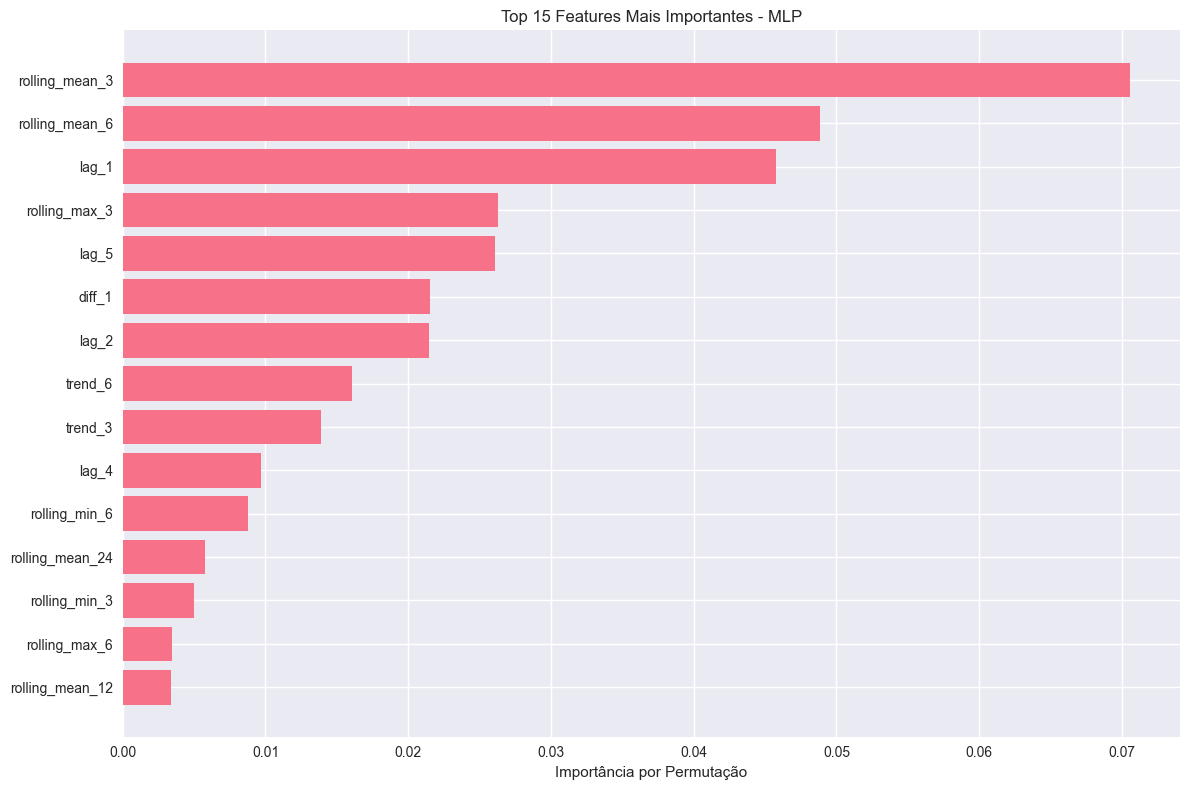

In [19]:
# Feature importance usando permutação
from sklearn.inspection import permutation_importance

print("\n=== Análise de Importância das Features ===")
print("Calculando importância por permutação...")

# Usar amostra menor para acelerar
sample_size = min(1000, len(X_test_scaled))
perm_importance = permutation_importance(
    best_mlp, X_test_scaled[:sample_size], y_test.iloc[:sample_size],
    n_repeats=5, random_state=42
)

# Criar DataFrame com importâncias
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("\nTop 15 features mais importantes:")
print(feature_importance_df.head(15))

# Visualizar importância das features
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância por Permutação')
plt.title('Top 15 Features Mais Importantes - MLP')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'{output_dir}/mlp_05_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# Salvar importâncias
feature_importance_df.to_csv(f'{output_dir}/mlp_feature_importance.csv', index=False)

## 8. Visualização das Previsões

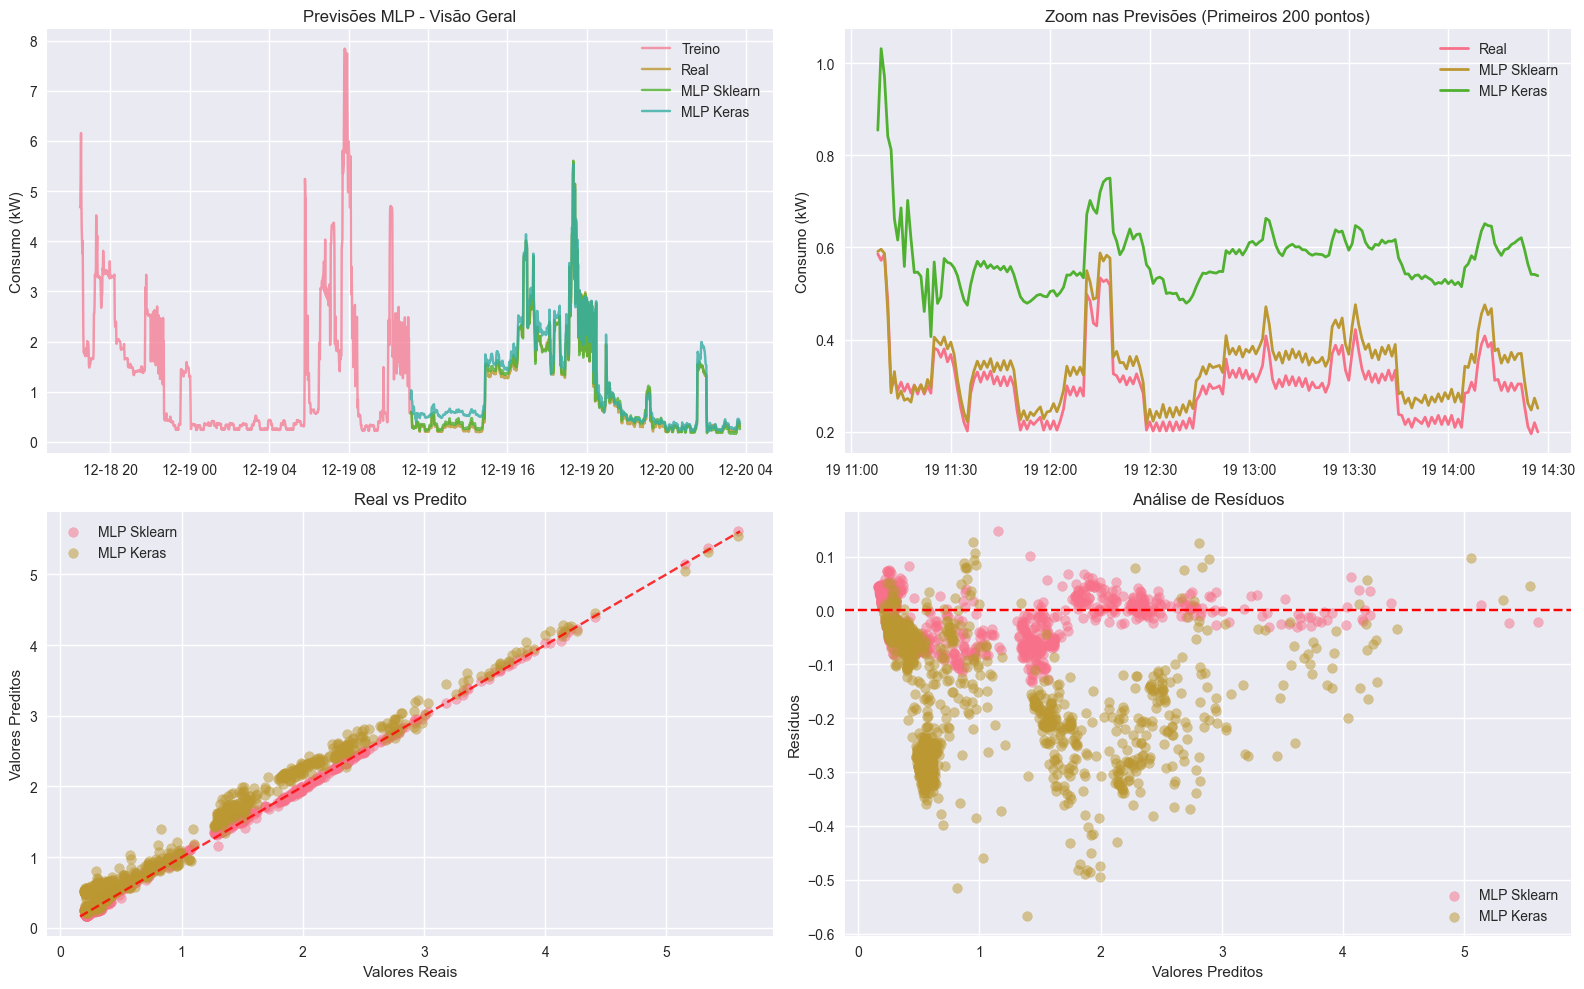

In [20]:
# Visualizar previsões
plt.figure(figsize=(16, 10))

# Plot 1: Série completa
plt.subplot(2, 2, 1)
n_plot = min(1000, len(y_train))
plt.plot(y_train.index[-n_plot:], y_train.iloc[-n_plot:], label='Treino', alpha=0.7)
plt.plot(y_test.index, y_test, label='Real', alpha=0.8)
plt.plot(y_test.index, y_pred_test, label='MLP Sklearn', alpha=0.8)
if y_pred_keras_final is not None:
    plt.plot(y_test.index, y_pred_keras_final, label='MLP Keras', alpha=0.8)
plt.title('Previsões MLP - Visão Geral')
plt.ylabel('Consumo (kW)')
plt.legend()

# Plot 2: Zoom nas previsões
plt.subplot(2, 2, 2)
zoom_size = min(200, len(y_test))
plt.plot(y_test.index[:zoom_size], y_test.iloc[:zoom_size], label='Real', linewidth=2)
plt.plot(y_test.index[:zoom_size], y_pred_test[:zoom_size], label='MLP Sklearn', linewidth=2)
if y_pred_keras_final is not None:
    plt.plot(y_test.index[:zoom_size], y_pred_keras_final[:zoom_size], label='MLP Keras', linewidth=2)
plt.title('Zoom nas Previsões (Primeiros 200 pontos)')
plt.ylabel('Consumo (kW)')
plt.legend()

# Plot 3: Scatter plot Real vs Predito
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_pred_test, alpha=0.5, label='MLP Sklearn')
if y_pred_keras_final is not None:
    plt.scatter(y_test, y_pred_keras_final, alpha=0.5, label='MLP Keras')
    
# Linha diagonal perfeita
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Real vs Predito')
plt.legend()

# Plot 4: Residuos
plt.subplot(2, 2, 4)
residuals_sklearn = y_test - y_pred_test
plt.scatter(y_pred_test, residuals_sklearn, alpha=0.5, label='MLP Sklearn')
if y_pred_keras_final is not None:
    residuals_keras = y_test - y_pred_keras_final
    plt.scatter(y_pred_keras_final, residuals_keras, alpha=0.5, label='MLP Keras')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Análise de Resíduos')
plt.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/mlp_06_predictions_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Análise de Erros e Distribuições

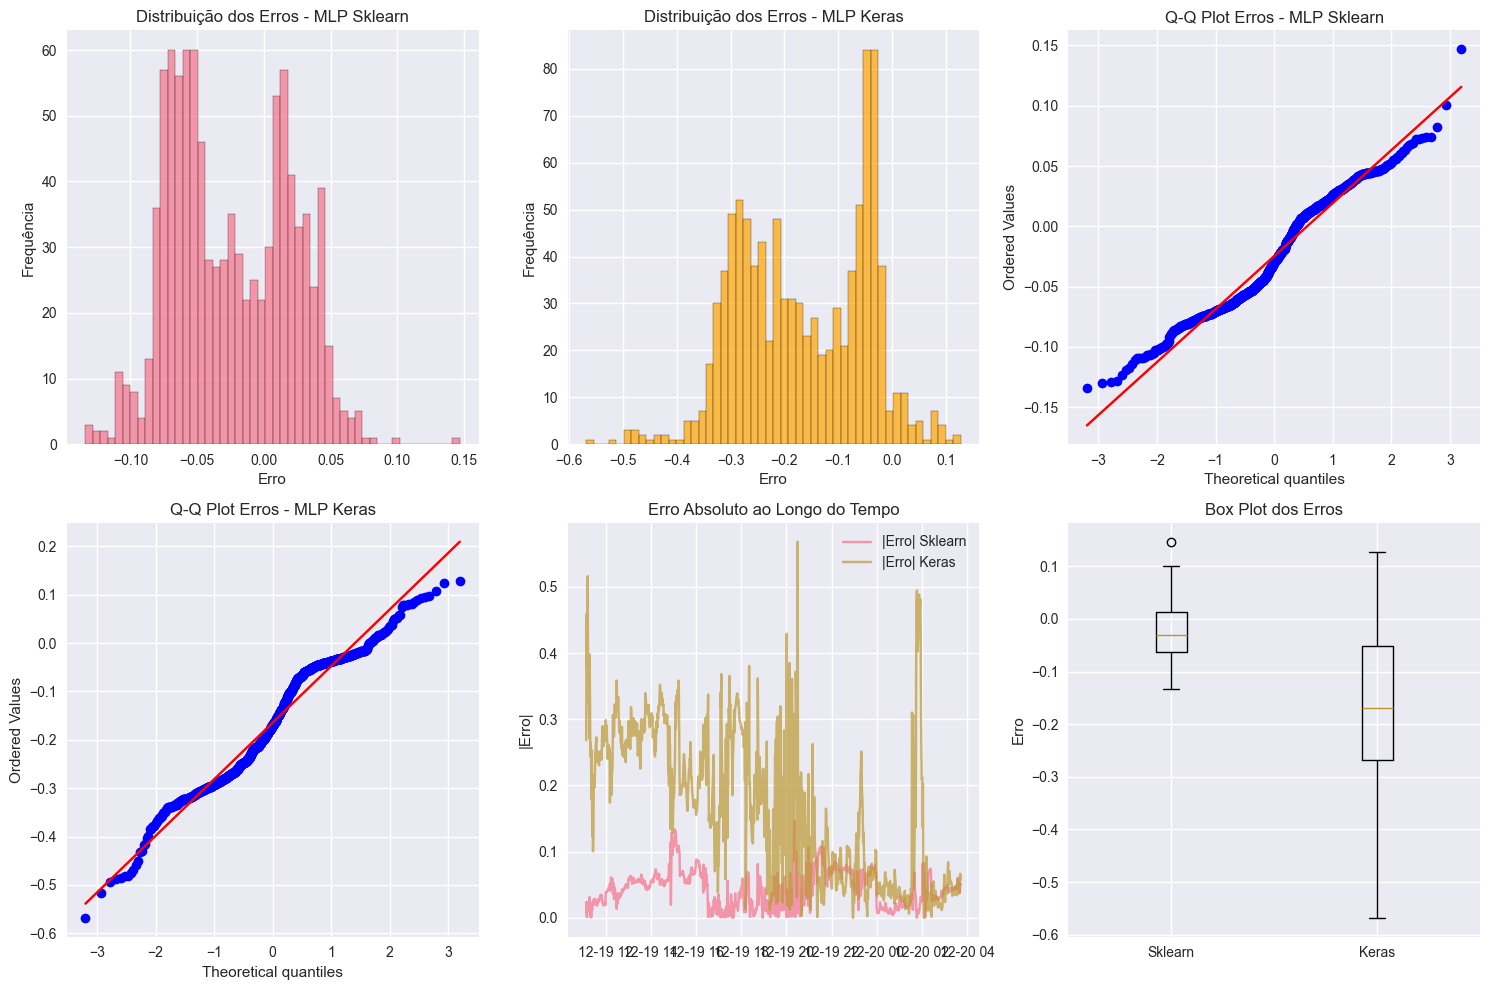


=== Estatísticas dos Erros ===
MLP Sklearn:
  Média dos erros: -0.024711
  Std dos erros: 0.044559
  Erro máximo: 0.146837
  95% dos erros < 0.084972

MLP Keras:
  Média dos erros: -0.164489
  Std dos erros: 0.119089
  Erro máximo: 0.568179
  95% dos erros < 0.333716


In [21]:
# Análise detalhada dos erros
plt.figure(figsize=(15, 10))

# Distribuição dos erros
plt.subplot(2, 3, 1)
residuals_sklearn = y_test - y_pred_test
plt.hist(residuals_sklearn, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribuição dos Erros - MLP Sklearn')
plt.xlabel('Erro')
plt.ylabel('Frequência')

if y_pred_keras_final is not None:
    plt.subplot(2, 3, 2)
    residuals_keras = y_test - y_pred_keras_final
    plt.hist(residuals_keras, bins=50, alpha=0.7, edgecolor='black', color='orange')
    plt.title('Distribuição dos Erros - MLP Keras')
    plt.xlabel('Erro')
    plt.ylabel('Frequência')

# Q-Q plot dos erros
plt.subplot(2, 3, 3)
stats.probplot(residuals_sklearn, dist="norm", plot=plt)
plt.title('Q-Q Plot Erros - MLP Sklearn')

if y_pred_keras_final is not None:
    plt.subplot(2, 3, 4)
    stats.probplot(residuals_keras, dist="norm", plot=plt)
    plt.title('Q-Q Plot Erros - MLP Keras')

# Erro ao longo do tempo
plt.subplot(2, 3, 5)
plt.plot(y_test.index, np.abs(residuals_sklearn), alpha=0.7, label='|Erro| Sklearn')
if y_pred_keras_final is not None:
    plt.plot(y_test.index, np.abs(residuals_keras), alpha=0.7, label='|Erro| Keras')
plt.title('Erro Absoluto ao Longo do Tempo')
plt.ylabel('|Erro|')
plt.legend()

# Box plot comparativo
plt.subplot(2, 3, 6)
if y_pred_keras_final is not None:
    plt.boxplot([residuals_sklearn, residuals_keras], labels=['Sklearn', 'Keras'])
else:
    plt.boxplot([residuals_sklearn], labels=['Sklearn'])
plt.title('Box Plot dos Erros')
plt.ylabel('Erro')

plt.tight_layout()
plt.savefig(f'{output_dir}/mlp_07_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Estatísticas dos erros
print("\n=== Estatísticas dos Erros ===")
print(f"MLP Sklearn:")
print(f"  Média dos erros: {residuals_sklearn.mean():.6f}")
print(f"  Std dos erros: {residuals_sklearn.std():.6f}")
print(f"  Erro máximo: {residuals_sklearn.abs().max():.6f}")
print(f"  95% dos erros < {np.percentile(np.abs(residuals_sklearn), 95):.6f}")

if y_pred_keras_final is not None:
    print(f"\nMLP Keras:")
    print(f"  Média dos erros: {residuals_keras.mean():.6f}")
    print(f"  Std dos erros: {residuals_keras.std():.6f}")
    print(f"  Erro máximo: {residuals_keras.abs().max():.6f}")
    print(f"  95% dos erros < {np.percentile(np.abs(residuals_keras), 95):.6f}")

## 10. Salvamento dos Resultados

In [22]:
# Compilar todos os resultados
mlp_results = {
    'model_type': 'MLP',
    'sklearn_mlp': {
        'best_params': grid_search.best_params_,
        'metrics': {
            'train_rmse': float(train_rmse),
            'test_rmse': float(test_rmse),
            'train_mae': float(train_mae),
            'test_mae': float(test_mae),
            'train_r2': float(train_r2),
            'test_r2': float(test_r2),
            'test_mape': float(test_mape),
            'cv_rmse_mean': float(cv_rmse_scores.mean()),
            'cv_rmse_std': float(cv_rmse_scores.std())
        },
        'overfitting_percentage': float(overfitting_sklearn)
    },
    'feature_importance': feature_importance_df.to_dict('records'),
    'data_info': {
        'total_samples': len(features_df),
        'train_samples': len(X_train),
        'test_samples': len(X_test),
        'n_features': X_train.shape[1],
        'start_date': str(features_df.index.min()),
        'end_date': str(features_df.index.max())
    }
}

# Adicionar resultados Keras se disponível
if KERAS_AVAILABLE and keras_results:
    best_keras_result = min(keras_results, key=lambda x: x['rmse'])
    
    # Métricas do modelo final
    final_keras_rmse = np.sqrt(mean_squared_error(y_test, y_pred_keras_final))
    final_keras_mae = mean_absolute_error(y_test, y_pred_keras_final)
    final_keras_r2 = r2_score(y_test, y_pred_keras_final)
    final_keras_mape = np.mean(np.abs((y_test - y_pred_keras_final) / y_test)) * 100
    
    mlp_results['keras_mlp'] = {
        'best_architecture': best_keras_result['architecture'],
        'metrics': {
            'test_rmse': float(final_keras_rmse),
            'test_mae': float(final_keras_mae),
            'test_r2': float(final_keras_r2),
            'test_mape': float(final_keras_mape)
        },
        'all_architectures': keras_results
    }

# Salvar resultados
with open(f'{output_dir}/mlp_results.json', 'w') as f:
    json.dump(mlp_results, f, indent=2)

# Salvar previsões
predictions_df = pd.DataFrame({
    'real': y_test,
    'mlp_sklearn': y_pred_test
}, index=y_test.index)

if y_pred_keras_final is not None:
    predictions_df['mlp_keras'] = y_pred_keras_final

predictions_df.to_csv(f'{output_dir}/mlp_predictions.csv')

print(f"\n=== Arquivos Salvos ===")
print(f"Resultados: {output_dir}/mlp_results.json")
print(f"Previsões: {output_dir}/mlp_predictions.csv")
print(f"Modelo Sklearn: {output_dir}/mlp_sklearn_model.pkl")
print(f"Scaler: {output_dir}/mlp_scaler.pkl")
if KERAS_AVAILABLE and best_keras_model:
    print(f"Modelo Keras: {output_dir}/mlp_keras_model.h5")
print(f"Feature Importance: {output_dir}/mlp_feature_importance.csv")
print(f"Gráficos: {output_dir}/mlp_01-07_*.png")

# Resumo final
print(f"\n=== Resumo Final - MLP ===")
print(f"Melhor modelo: {'Keras' if KERAS_AVAILABLE and y_pred_keras_final is not None and final_keras_rmse < test_rmse else 'Scikit-learn'}")
print(f"\nScikit-learn MLP:")
print(f"  Arquitetura: {grid_search.best_params_['hidden_layer_sizes']}")
print(f"  RMSE: {test_rmse:.6f}")
print(f"  MAPE: {test_mape:.2f}%")
print(f"  R²: {test_r2:.4f}")
print(f"  Overfitting: {overfitting_sklearn:.2f}%")

if KERAS_AVAILABLE and y_pred_keras_final is not None:
    print(f"\nKeras MLP:")
    print(f"  Arquitetura: {best_architecture}")
    print(f"  RMSE: {final_keras_rmse:.6f}")
    print(f"  MAPE: {final_keras_mape:.2f}%")
    print(f"  R²: {final_keras_r2:.4f}")

print(f"\nFeatures mais importantes:")
for i, row in feature_importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.6f}")


=== Arquivos Salvos ===
Resultados: ../../out/household_consumption/MLP/mlp_results.json
Previsões: ../../out/household_consumption/MLP/mlp_predictions.csv
Modelo Sklearn: ../../out/household_consumption/MLP/mlp_sklearn_model.pkl
Scaler: ../../out/household_consumption/MLP/mlp_scaler.pkl
Modelo Keras: ../../out/household_consumption/MLP/mlp_keras_model.h5
Feature Importance: ../../out/household_consumption/MLP/mlp_feature_importance.csv
Gráficos: ../../out/household_consumption/MLP/mlp_01-07_*.png

=== Resumo Final - MLP ===
Melhor modelo: Scikit-learn

Scikit-learn MLP:
  Arquitetura: (100, 50, 25)
  RMSE: 0.050933
  MAPE: 9.62%
  R²: 0.9971
  Overfitting: 415.93%

Keras MLP:
  Arquitetura: [64, 32]
  RMSE: 0.203039
  MAPE: 34.41%
  R²: 0.9535

Features mais importantes:
  rolling_mean_3: 0.070537
  rolling_mean_6: 0.048876
  lag_1: 0.045744
  rolling_max_3: 0.026267
  lag_5: 0.026104
